### Setup

In [1]:
import pandas as pd
import numpy as np
import os
from time import time

In [2]:
#import sys
#sys.path.append(os.path.abspath('..'))#sys.path[0] + '/..') 
from vb_estimators import  LinRegSupreme,LinSVR,RBFSVR,ENet,L1Lars,GBR,HGBR,FlexiblePipe
from vb_helper import VBHelper
from vb_cross_validator import regressor_q_stratified_cv

no daal4py


In [3]:

from warnings import filterwarnings
filterwarnings('ignore')


### setup the experiment/project
#### note the 'run_stacked' kwarg that can be set to create the stacked_regressor

In [4]:
gridpoints=5
kwargs=dict(
    run_stacked=True,
    test_share=0.2,#keep at 0 for small datasets
    cv_folds=5,
    cv_reps=2,
    #cv_groupcount=5,
    cv_strategy=('quantile',5), # for stratified cv
    random_state=2 # random_state for reproducibility
)
vbhelper=VBHelper(**kwargs)

In [5]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
vbhelper.scorer_list=scorer_list

##### Example Dataset

In [6]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [7]:
#The user sets the variables to use for x and y.
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [8]:

shuf=np.arange(y_df.shape[0])
np.random.seed(0)
np.random.shuffle(shuf)
X_df=X_df.iloc[shuf]
y_df=y_df.iloc[shuf]
vbhelper.setData(X_df,y_df)

### setup the analytical pipelines
#### note the inner_cv_dict and prep_dict that are used to consolidate vb_estimator kwargs and to facilitate the divison between prep and post steps.

In [9]:
inner_cv_dict={'cv_reps':1,'cv_folds':5,'cv_strategy':('quantile',5)}
inner_cv=vbhelper.getCV(cv_dict=inner_cv_dict)

prep_dict={'impute_strategy':'impute_knn5','cat_idx':vbhelper.cat_idx}

pipe_kwargs=dict(do_prep=not vbhelper.run_stacked,prep_dict=prep_dict,inner_cv=inner_cv,gridpoints=gridpoints,cat_idx=vbhelper.cat_idx,float_idx=vbhelper.float_idx,bestT=False)
pipe_dict={
    #'gradient-boosting-reg':{'pipe':GBR,'pipe_kwargs':dict(
    #    prep_dict=prep_dict,do_prep=False)},
    #'lin-reg-supreme':{'pipe':LinRegSupreme,'pipe_kwargs':pipe_kwargs}, 
    #'powXB-least-sq':{'pipe':FlexiblePipe,'pipe_kwargs':{**pipe_kwargs,'flex_kwargs':{'form':'powXB'}}}),
    #'expXB-least-sq':{'pipe':FlexiblePipe,'pipe_kwargs':{**pipe_kwargs,'flex_kwargs':{'form':'expXB'}}}), #expXB is default
    #'nonlinear-search-least-sq': {'pipe':FlexiblePipe,'pipe_kwargs':{**pipe_kwargs,'functional_form_search':True}},
    #'robust-powXB-least-sq':{'pipe':FlexiblePipe,'pipe_kwargs':{**pipe_kwargs,'flex_kwargs':{'form':'powXB','robust':True}}},
    #'robust-expXB-least-sq':{'pipe':FlexiblePipe,'pipe_kwargs':{**pipe_kwargs,'flex_kwargs':{'form':'expXB','robust':True}}}, #expXB is default
    #'robust-nonlinear-search-least-sq': {'pipe':FlexiblePipe,'pipe_kwargs':{**pipe_kwargs,'functional_form_search':True,'flex_kwargs':{'robust':True}}},
    #'histogram-gradient-boosting-reg':{'pipe':HGBR,'pipe_kwargs':{'prep_dict':{'cat_idx':vbhelper.cat_idx}}},
    
    
    'elastic-net':{'pipe':ENet,'pipe_kwargs':pipe_kwargs}, 
    #'linear-svr-cv':{'pipe':LinSVR,'pipe_kwargs':pipe_kwargs}
    'rbf-svr-cv':{'pipe':RBFSVR,'pipe_kwargs':pipe_kwargs}, 
    'lassolars':{'pipe':L1Lars,'pipe_kwargs':pipe_kwargs},
    }


#estimator_dict={'multi_pipe':{'pipe':MultiPipe(pipelist=[(k,v) for k,v in estimator_dict.items()],cat_idx=vbhelper.cat_idx)}
vbhelper.setEstimatorDict(pipe_dict)
vbhelper.setModelDict()
#vbhelper.model_dict={key:val() for key,val in vbhelper.estimator_dict.items()} # they will be models once .fit is called

### create a smaller test run to check runtime, debug, etc.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_df,y_df,test_size=0.5) #just for debugging

In [11]:
i=0
for name,est in vbhelper.model_dict.items():
    start=time()
    i+=1;print(name)
    est.fit(X_train,y_train)
    print('train R2:',est.score(X_train,y_train))
    if not X_test is None:print('test R2:',est.score(X_test,y_test))
    end=time()
    print(f'runtime:{(end-start)/60} min.\n')


multi_pipe
train R2: 0.6354534035690411
test R2: 0.4511770822932589
runtime:0.33247354030609133 min.



In [12]:
if vbhelper.run_stacked:
    mp=vbhelper.model_dict['multi_pipe']
    fitted_ipipe_dict=mp.build_individual_fitted_pipelines()
    print(fitted_ipipe_dict['lassolars'].score(X_test,y_test))

0.4009612518400304


### end small test-run debugging

In [13]:
vbhelper.runCrossValidate()

multi_pipe,[('neg_mean_squared_error', -7725.376525860163), ('neg_mean_absolute_error', -64.32572445497375), ('r2', 0.43390525730444107)], runtime:2.397721362113953 min.


In [14]:
#plot cv_yhat

#### graphs and table to summarize results

In [15]:
vbhelper.buildCVScoreDict()

In [16]:
vbhelper.cv_score_dict

{'elastic-net': {'neg_mean_squared_error': array([ -6842.03270315,  -9751.05289541,  -7906.85007892,  -7732.43807989,
         -10539.56984284, -12387.01054691,  -8385.10623927,  -7594.18194199,
          -6843.82065339,  -6629.30540504]),
  'neg_mean_absolute_error': array([-63.64469946, -71.10635461, -71.95570581, -68.01147369,
         -68.13611362, -73.54948434, -72.11742683, -66.5293364 ,
         -65.68210921, -62.00487637]),
  'r2': array([0.50520224, 0.32891949, 0.27846271, 0.3667236 , 0.36317124,
         0.32478481, 0.35429463, 0.42314528, 0.37245887, 0.47615798])},
 'rbf-svr-cv': {'neg_mean_squared_error': array([ -7529.46663047,  -8397.47560094,  -7613.46279556,  -6798.89140352,
         -10656.75599041, -11242.9653115 ,  -7216.44361162,  -8345.98872744,
          -5958.76233657,  -7241.61366087]),
  'neg_mean_absolute_error': array([-63.14684122, -62.04112323, -65.51939242, -61.11349704,
         -67.98482354, -66.22720454, -63.92391712, -62.77782521,
         -60.24145536

In [17]:
vbhelper.viewCVScoreDict()

scores for scorer: neg_mean_squared_error:
    multi_pipe:-7725.376525860163
scores for scorer: neg_mean_absolute_error:
    multi_pipe:-64.32572445497375
scores for scorer: r2:
    multi_pipe:0.43390525730444107


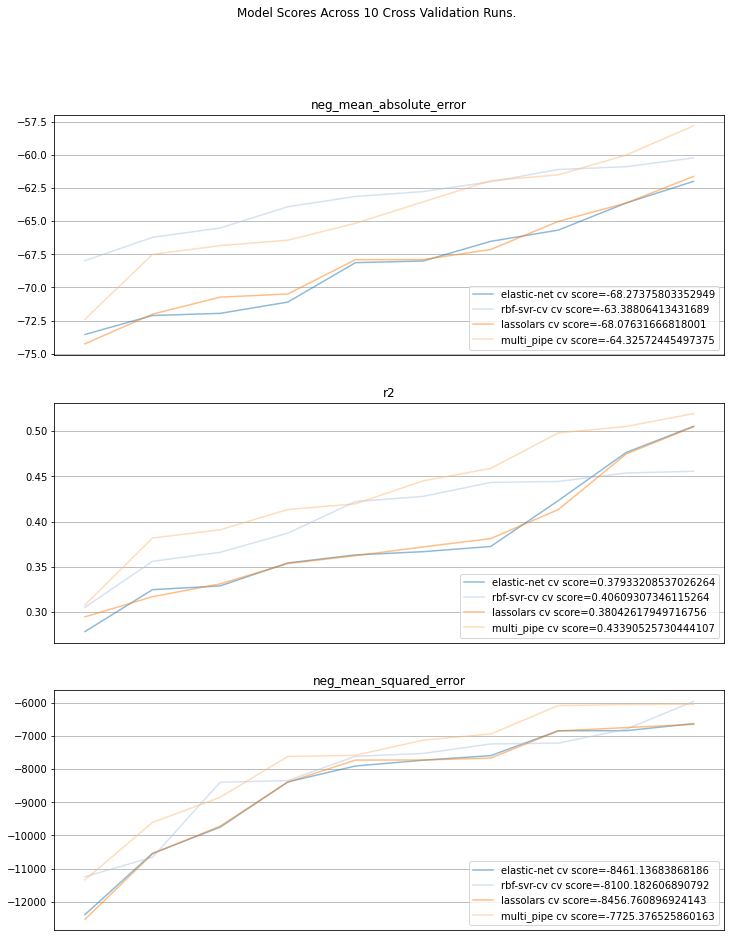

In [18]:
vbhelper.plotCVScores(sort=1)

In [19]:
vbhelper.predictCVYhat()

In [20]:
vbhelper.jsonifyProjectCVResults()

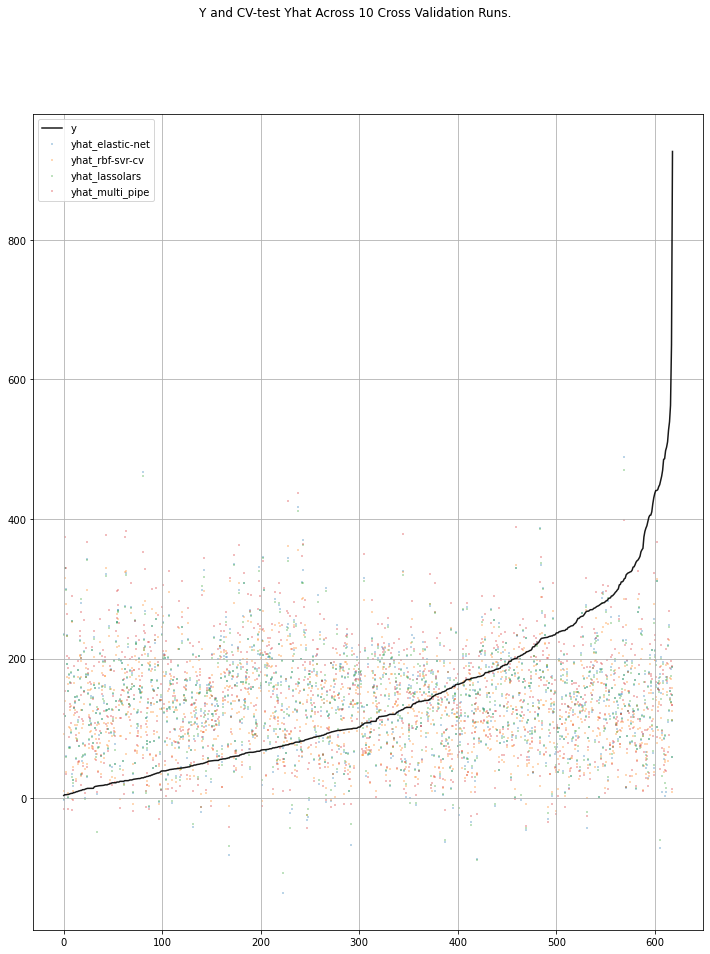

In [21]:
vbhelper.plotCVYhat(single_plot=True)

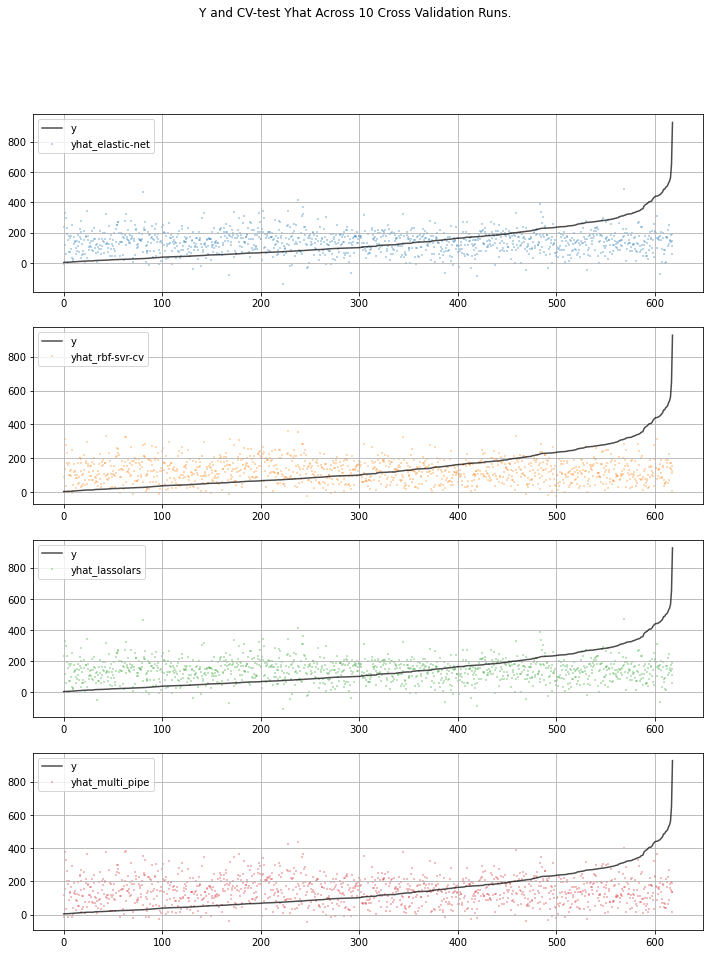

In [22]:
vbhelper.plotCVYhat(single_plot=False)

## Next, user selects pipeline, final model is fit and ready for prediction